# Sentiment Analysis on Movie Reviews
## Classify the sentiment of sentences from the Rotten Tomatoes dataset

In this Kaggle project, I attempt to classify the sentiment of sentences from the [Rotten Tomatoes](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews) dataset using several feature engineering (tokenisation, cleaning the text and removing stop words, using Word2vec embedding, lematization and normalisation) and Machine Learning techniques (including Deep Learning). Because removing too many stop words slightly decreased validation performance for the majority of models, I chose to only remove punctuation and some common articles (such as "a", "an"), to only use lowercase writing and to apply lematization. Before applying the Word2vec embedding on the data, I first updated the weights of the word vectors with the Google News corpus. This improved the accuracy by roughly 5% -6%. Normalisation (min-max scaling) further improved the accuracy of the model (in some cases close to 10%). The best model in terms of balancing bias and variance (had a relatively higher accuracy and did not overfit the data) was a tuned feed-forward neural network with one hidden layer.

The sentiment labels are:

0. negative
1. somewhat negative
2. neutral
3. somewhat positive
4. positive

The workflow consists of the following steps:


* Exploring the data and creating new features
* Pre-processing and vectorization
* Developing a classifier for predicting the sentiment

First, I imported all the packages necessary for visualisation and pre-processing and set my working directory.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from textblob import TextBlob
from wordcloud import WordCloud
from nltk import word_tokenize
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
warnings.filterwarnings(action = 'ignore') 

import os
for dirname, _, filenames in os.walk('D:\Study\Datasets\Sentiment Analysis on Movie Reviews'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Next, I read the data downloaded from Kaggle and created the training and test datasets.

In [ ]:
training = pd.read_csv("/content/train.tsv", sep='\t')
test = pd.read_csv("/content/test.tsv", sep='\t')

In [ ]:
%matplotlib inline
training.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## Exploring the data and creating new features

In order to explore the data and perform further transformations, I first joined the training and testing datasets.

In [ ]:
training['train_test'] = 1
test['train_test'] = 0
test['Sentiment'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

pd.set_option('display.max_colwidth', 100000)

all_data.Phrase=all_data.Phrase.str.strip()

In [ ]:
all_data.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,train_test
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1
2,3,1,A series,2.0,1
3,4,1,A,2.0,1
4,5,1,series,2.0,1
5,6,1,of escapades demonstrating the adage that what is good for the goose,2.0,1
6,7,1,of,2.0,1
7,8,1,escapades demonstrating the adage that what is good for the goose,2.0,1
8,9,1,escapades,2.0,1
9,10,1,demonstrating the adage that what is good for the goose,2.0,1


In [ ]:
all_data.shape

(222352, 5)

Let us  is now create a frequency count for the Sentiment column.

In [ ]:
all_data.Sentiment.value_counts()

2.0    79582
3.0    32927
1.0    27273
4.0     9206
0.0     7072
Name: Sentiment, dtype: int64

2.0    0.357910
3.0    0.148085
1.0    0.122657
4.0    0.041403
0.0    0.031805
Name: Sentiment, dtype: float64


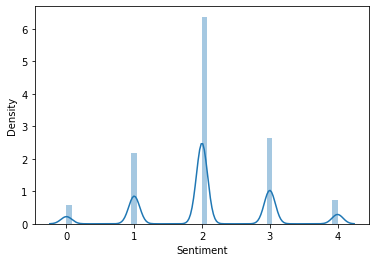

In [ ]:
print(all_data.Sentiment.value_counts() / len(all_data))

%matplotlib inline
sns.distplot(all_data.loc[all_data['train_test']==1,"Sentiment"])

The majority of reviews (around 36%) are neutral. 

In [ ]:
word_tokens = [word_tokenize(review.lower()) for review in all_data.Phrase]

print(word_tokens[0:5])

[['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.'], ['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['a', 'series'], ['a'], ['series']]


In [ ]:
len_tokens = []

# Iterate over the word_tokens list
for i in range(len(word_tokens)):
    len_tokens.append(len(word_tokens[i]))
    
all_data['n_tokens'] = len_tokens

In [ ]:
all_data.sort_values(by='n_tokens', ascending=False).head(20)

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens
3776,159837,8685,"The film is faithful to what one presumes are the book 's twin premises -- that we become who we are on the backs of our parents , but we have no idea who they were at our age ; and that time is a fleeting and precious commodity no matter how old you are .",NaN,0,56
3777,159838,8685,"The film is faithful to what one presumes are the book 's twin premises -- that we become who we are on the backs of our parents , but we have no idea who they were at our age ; and that time is a fleeting and precious commodity no matter how old you are",NaN,0,55
18578,18579,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie .",1.0,1,53
18579,18580,817,"If you are curious to see the darker side of what 's going on with young TV actors -LRB- Dawson Leery did what ?!? -RRB- , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie",1.0,1,52
75357,75358,3866,"Build some robots , haul 'em to the theatre with you for the late show , and put on your own Mystery Science Theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year .",0.0,1,52
35598,35599,1678,"It cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- wherever it takes you .",4.0,1,52
87835,87836,4563,"There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .",4.0,1,52
105155,105156,5555,"... spiced with humor -LRB- ' I speak fluent flatula , ' advises Denlopp after a rather , er , bubbly exchange with an alien deckhand -RRB- and witty updatings -LRB- Silver 's parrot has been replaced with Morph , a cute alien creature who mimics everyone and everything around -RRB-",3.0,1,51
59649,59650,3010,"It 's a bad sign when you 're rooting for the film to hurry up and get to its subjects ' deaths just so the documentary will be over , but it 's indicative of how uncompelling the movie is unless it happens to cover your particular area of interest .",0.0,1,51
80457,80458,4145,"If S&M seems like a strange route to true love , maybe it is , but it 's to this film 's -LRB- and its makers ' -RRB- credit that we believe that that 's exactly what these two people need to find each other -- and themselves .",3.0,1,51


The new columns created consist of Polarity, Subjectivity and the number of tokens (nb. of words per observation). Polarity ranges between -1 and 1; with a polarity greater than 0.5 illustrating a positive sentiment, a polarity lower than -0.5 a negative one and a polarity between -0.5 and 0.5 illustrating a neutral sentiment. Subjectivity, on the other hand ranges between 0 and 1. A higher subjectivity suggests a more emotionally charged word/phrase.

In [ ]:
from pandas import DataFrame

def Polarity(x):
    my_valance = TextBlob(x)
    return my_valance.sentiment.polarity

def Subjectivity(x):
    my_valance = TextBlob(x)
    return my_valance.sentiment.subjectivity

all_data['Polarity']=all_data['Phrase'].apply(Polarity)
all_data['Subjectivity']=all_data['Phrase'].apply(Subjectivity)

In [ ]:
all_data.head(20)

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens,Polarity,Subjectivity
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1,37,0.4,0.38125
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1,14,0.7,0.60000
2,3,1,A series,2.0,1,2,0.0,0.00000
3,4,1,A,2.0,1,1,0.0,0.00000
4,5,1,series,2.0,1,1,0.0,0.00000
5,6,1,of escapades demonstrating the adage that what is good for the goose,2.0,1,12,0.7,0.60000
6,7,1,of,2.0,1,1,0.0,0.00000
7,8,1,escapades demonstrating the adage that what is good for the goose,2.0,1,11,0.7,0.60000
8,9,1,escapades,2.0,1,1,0.0,0.00000
9,10,1,demonstrating the adage that what is good for the goose,2.0,1,10,0.7,0.60000


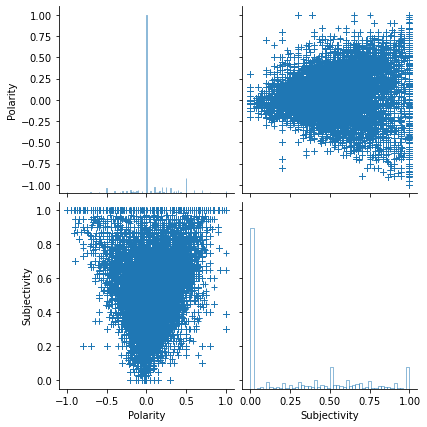

In [ ]:
%matplotlib inline
sns.pairplot(all_data.loc[all_data['train_test']==1,["Polarity","Subjectivity"]],plot_kws=dict(marker="+", linewidth=1),diag_kws=dict(fill=False),
height=3)

Although the majority of observations has a polarity of 0 (neutral); corresponding to a Sentiment of 2 (agreeing with the distribution of the Sentiment distribution plot), it can clearly be noticed how the second (index 1) polarity value (0.7- positive) overestimates the  positivity of the first two sentences sentences when compared to the respective sentiment value (2- neutral). This is because polarity alone does not distinguish context nor sarcasm. The subjectivity value of 0.6 suggests a rather emotionally charged phrase. The same applies to row 6 (index 5). Notice how the presence of "A series" in the phrase does not influence polarity nor subjectivity in any way. A big reason for the frequent values of 0 afferent to both the polarity and subjectivity columns consists of the presence of rows that only have stop words in the Phrase column.

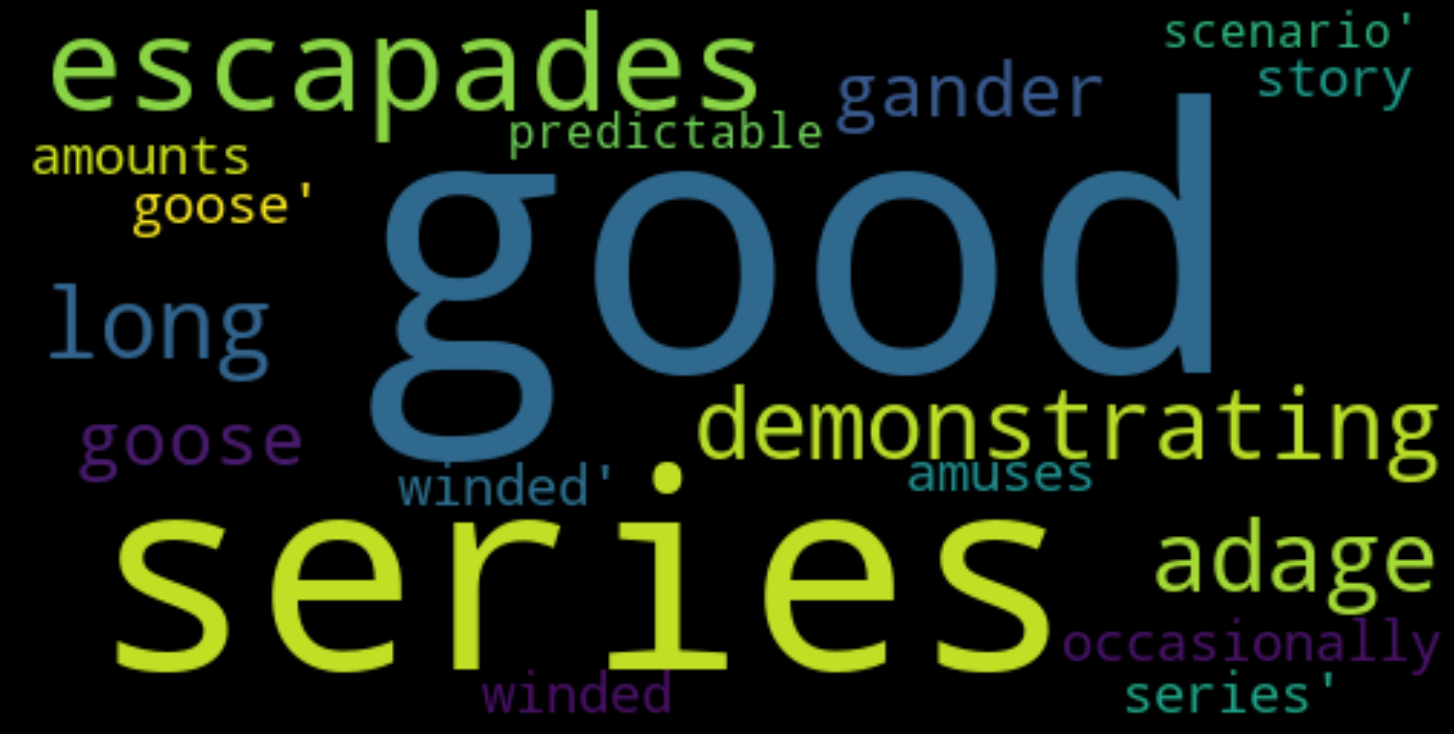

In [ ]:
text = all_data.Phrase.values
wordcloud = WordCloud(
    width = 500,
    height = 250,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

According to the word cloud, the second most frequent word is "series"; which does not have neither a positive nor negative meaning. This word does not bring any added value and is repeated for most of the series reviewed on Rotten Tomatoes. This noun along with others and articles such as "a" and "the" are candidates for stop words (i.e. removing them might be beneficial).

## Pre-processing and vectorization


In [ ]:
x_train = all_data[all_data.train_test==1]
x_test = all_data[all_data.train_test==0]
y_train = all_data[all_data.train_test==1].Sentiment

In [ ]:
x_train.head()

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens,Polarity,Subjectivity
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1,37,0.4,0.38125
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1,14,0.7,0.60000
2,3,1,A series,2.0,1,2,0.0,0.00000
3,4,1,A,2.0,1,1,0.0,0.00000
4,5,1,series,2.0,1,1,0.0,0.00000


In [ ]:
#First we clean the data

tokenized_text = all_data['Phrase'].apply(lambda x: simple_preprocess(x.lower(), deacc=True))
WNlemmatizer = WordNetLemmatizer()

lemmatized_tokens = tokenized_text.apply(lambda x: [WNlemmatizer.lemmatize(i) for i in x])

In [ ]:
all_data['tokenized_text'] = lemmatized_tokens

In [ ]:
all_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,train_test,n_tokens,Polarity,Subjectivity,tokenized_text
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,1,37,0.4,0.38125,"[series, of, escapade, demonstrating, the, adage, that, what, is, good, for, the, goose, is, also, good, for, the, gander, some, of, which, occasionally, amuses, but, none, of, which, amount, to, much, of, story]"
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,1,14,0.7,0.60000,"[series, of, escapade, demonstrating, the, adage, that, what, is, good, for, the, goose]"
2,3,1,A series,2.0,1,2,0.0,0.00000,[series]
3,4,1,A,2.0,1,1,0.0,0.00000,[]
4,5,1,series,2.0,1,1,0.0,0.00000,[series]


[list(['series', 'of', 'escapade', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amount', 'to', 'much', 'of', 'story'])
 list(['series', 'of', 'escapade', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'])
 list(['series']) list([]) list(['series'])]


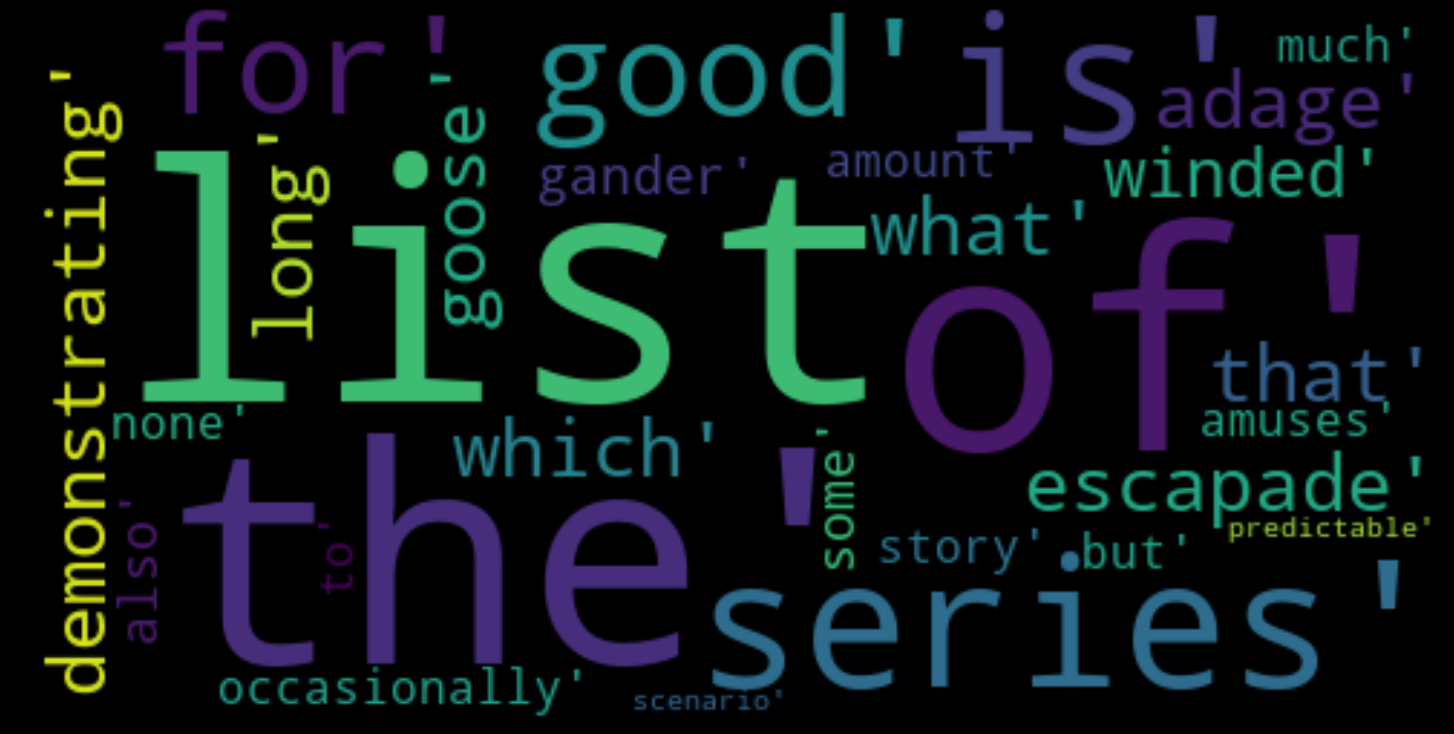

In [ ]:
tokenized_text = pd.Series(all_data['tokenized_text']).values

print(tokenized_text[0:5])

wordcloud = WordCloud(
    width = 500,
    height = 250,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(tokenized_text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
import time

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        elif self.epoch % 100 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        
        
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-02-01 14:01:39--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.106.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.106.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  99.1MB/s    in 17s     

2021-02-01 14:01:56 (94.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above

In [ ]:
# Train a bigram detector.
bigram_transformer = Phrases(tokenized_text)

# Create Skip-Gram model 
w2v_model = Word2Vec(min_count = 2,  size = 300,window = 15, workers=20,sg=1,negative=5,sample=1e-05)
w2v_model.build_vocab(tokenized_text)
w2v_model_0 = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
w2v_model.build_vocab([list(w2v_model_0.vocab.keys())], update=True)
w2v_model.intersect_word2vec_format(EMBEDDING_FILE, binary=True, lockf=1.0)
  
# train the w2v model
start = time.time()
w2v_model.train(bigram_transformer[tokenized_text], 
                total_examples=w2v_model.corpus_count, 
                epochs=501, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()


print("elapsed time in seconds :"+ str(end - start))             

Loss after epoch 0: 1271860.25
Loss after epoch 100: 186200.0
Loss after epoch 200: 244340.0
Loss after epoch 300: 18848.0
Loss after epoch 400: 11616.0
Loss after epoch 500: 6768.0
elapsed time in seconds :3676.1479375362396


In [ ]:
words = list(w2v_model.wv.vocab)
print('Vocab size: '+str(len(words)))

Vocab size: 15806


In [ ]:
# Print results

print("Cosine similarity between 'goose' " + 
               "and 'gander' - Skip-Gram : ", 
    w2v_model.similarity('goose', 'gander')) 

print("Cosine similarity between 'story' " + 
               "and 'gander' - Skip-Gram : ", 
    w2v_model.similarity('story', 'gander')) 
      
print("Cosine similarity between 'story' " + 
               "and 'adage' - Skip-Gram : ", 
    w2v_model.similarity('story', 'gander'))

print("Cosine similarity between 'long' " + 
               "and 'winded' - Skip-Gram : ", 
    w2v_model.similarity('long', 'winded'))

Cosine similarity between 'goose' and 'gander' - Skip-Gram :  0.8457503
Cosine similarity between 'story' and 'gander' - Skip-Gram :  0.447054
Cosine similarity between 'story' and 'adage' - Skip-Gram :  0.447054
Cosine similarity between 'long' and 'winded' - Skip-Gram :  0.43583402


In [ ]:
# calculate: (gander - story) + goose = ?
result = w2v_model.most_similar(positive=['goose', 'gander'], negative=['story'], topn=1)
print(result)

[('demonstrating', 0.7546719312667847)]


The words 'goose' and 'gander' have, as expected, the highest cosine similarity as the 'gander' is the male goose. I would, hoever, expect a much lower cosine similarity for the pairs of words 'story' and 'gander', respectively 'story' and 'adage'. As expected, the pair 'long' and 'winded' has a somewhat high cosine similarity given that  'long-winded' means 'unecessarily long'; even though the primary meaning of 'winded' is not long. These estimates are mainly influenced by word pairs frequencies. Usually, the models based on Word2vec are trained on very large corpi of text. Here, and the accuracy of the similarity estimates is mainly impacted by the size, window and negative sample size hyperparameters of the Word2Vec() estimator.

Note: In order to improve the performance of the model, I updated the vector weights using the Google News corpus.

In [ ]:
result = w2v_model.most_similar(positive='good',topn=20)
print(result)

[('pretty', 0.6849404573440552), ('bad', 0.6797171831130981), ('fresnadillo', 0.6748459339141846), ('decent', 0.6670111417770386), ('better', 0.6663802266120911), ('great', 0.6549230217933655), ('serious', 0.6527841091156006), ('really', 0.6477358937263489), ('terrific', 0.6420391798019409), ('our', 0.6380504965782166), ('chance', 0.637020468711853), ('nice', 0.6361652612686157), ('what', 0.6272926926612854), ('come', 0.6258034110069275), ('excellent', 0.6240061521530151), ('sense', 0.6076582074165344), ('obviously', 0.6027170419692993), ('here', 0.6012381315231323), ('say', 0.5966446399688721), ('definitely', 0.5963605642318726)]


In [ ]:
result = w2v_model.most_similar(positive='bad',topn=20)
print(result)

[('good', 0.6797171831130981), ('terrible', 0.6711083650588989), ('lousy', 0.6614342927932739), ('horrible', 0.6567610502243042), ('right', 0.6166561841964722), ('playing', 0.606164276599884), ('home', 0.5948219299316406), ('awful', 0.5917574763298035), ('usual', 0.5893537402153015), ('wrong', 0.5852879285812378), ('poor', 0.5738152861595154), ('tough', 0.5697147846221924), ('worse', 0.5678142309188843), ('crummy', 0.5589063167572021), ('better', 0.5560203194618225), ('dreadful', 0.553294837474823), ('horrid', 0.5512940883636475), ('this', 0.5486893653869629), ('anyway', 0.5439966320991516), ('probably', 0.5402412414550781)]


Although for most of the part the word 'good' has a high similarity to positive words and the word 'bad' has a high cosine similarity to negative words, the words 'good' and 'bad' have a 67.97% cosine similarity. This might be due to the fact that the algorithm only looks at word pairs freuencies and is not able to detect sarcasm. Overall, the results are good enough given the relatively small size of the vocabulary in both the training and test data (even though the weights are updated using the Google News corpus).

In [ ]:
#Next, I will add zero padding and reshape the Word 2 Vec model to create a word vector array.
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_text), 300))

for i in range(len(tokenized_text)):
    wordvec_arrays[i,:] = word_vector(tokenized_text[i], 300)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(222352, 300)

In [ ]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.233679,0.136858,0.025814,0.298063,-0.149192,0.057479,0.295757,-0.206601,0.210727,0.418189,-0.299953,-0.472062,0.017515,0.117409,-0.423682,0.305885,0.089170,0.283373,-0.123751,-0.303640,0.068350,0.102878,0.043887,-0.057805,0.190079,0.000375,-0.320326,0.363933,0.068739,0.171228,-0.265451,-0.050127,-0.030546,0.109333,0.151109,0.091961,0.158127,-0.034343,0.305982,0.412413,...,0.001882,0.110908,-0.303058,0.052645,0.156659,0.460353,-0.184460,-0.191187,-0.299884,-0.124589,0.213097,0.382386,0.270759,0.095494,0.202971,-0.119779,0.000198,-0.251189,-0.282881,0.034342,0.199208,-0.225340,0.106380,0.229278,0.063432,0.012174,-0.357302,-0.041066,0.001356,0.170702,-0.311957,0.044873,-0.305397,-0.069104,-0.230240,-0.111527,0.223389,-0.192168,0.065253,-0.083630
1,0.283219,0.225772,0.000012,0.334808,-0.161489,0.133943,0.322093,-0.258204,0.255599,0.488654,-0.304203,-0.624068,0.011888,0.133778,-0.468943,0.337438,0.069797,0.327652,-0.162703,-0.408041,0.126672,0.238416,0.053074,-0.082535,0.140848,0.002627,-0.297031,0.430002,0.169641,0.188284,-0.269189,-0.093620,-0.018594,0.137580,0.211968,0.176878,0.184649,-0.053902,0.493508,0.432042,...,0.018970,0.161285,-0.282359,0.113016,0.185329,0.561844,-0.159689,-0.212953,-0.410337,-0.118897,0.185654,0.447819,0.344957,0.122585,0.210758,-0.138435,-0.002838,-0.212566,-0.299359,0.141058,0.204996,-0.282843,0.145542,0.174441,-0.016917,-0.030926,-0.398027,-0.023216,0.049412,0.160054,-0.290907,0.087305,-0.397207,-0.057442,-0.255615,-0.165050,0.246507,-0.244357,0.110398,-0.042483
2,-0.068898,0.372423,-0.113869,0.111909,0.197598,0.326926,0.278682,-0.247546,0.302735,0.555960,-0.194025,-0.505755,0.091070,0.193025,-0.427560,0.123388,0.039647,0.395496,-0.049603,-0.257771,0.445433,0.162690,-0.038440,-0.217993,0.006049,0.128104,-0.213589,0.559867,0.075139,0.077435,-0.497507,-0.127022,0.055202,-0.038972,0.186430,0.193918,0.353910,-0.228355,0.427315,0.189961,...,0.139564,0.593893,-0.068699,-0.120590,0.224568,0.432919,-0.109583,-0.048876,-0.281579,-0.151276,0.316659,0.241510,0.201031,0.187441,0.503676,-0.099870,-0.117386,-0.348814,-0.116212,-0.080448,0.080470,-0.529456,0.265887,0.084760,0.021549,-0.287797,-0.401485,-0.140354,0.013351,0.093536,-0.078993,-0.258188,-0.180037,-0.278556,-0.203341,-0.247724,0.138018,-0.184131,-0.046182,-0.178569
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.068898,0.372423,-0.113869,0.111909,0.197598,0.326926,0.278682,-0.247546,0.302735,0.555960,-0.194025,-0.505755,0.091070,0.193025,-0.427560,0.123388,0.039647,0.395496,-0.049603,-0.257771,0.445433,0.162690,-0.038440,-0.217993,0.006049,0.128104,-0.213589,0.559867,0.075139,0.077435,-0.497507,-0.127022,0.055202,-0.038972,0.186430,0.193918,0.353910,-0.228355,0.427315,0.189961,...,0.139564,0.593893,-0.068699,-0.120590,0.224568,0.432919,-0.109583,-0.048876,-0.281579,-0.151276,0.316659,0.241510,0.201031,0.187441,0.503676,-0.099870,-0.117386,-0.348814,-0.116212,-0.080448,0.080470,-0.529456,0.265887,0.084760,0.021549,-0.287797,-0.401485,-0.140354,0.013351,0.093536,-0.078993,-0.258188,-0.180037,-0.278556,-0.203341,-

In [ ]:
from sklearn.model_selection import train_test_split

x_train_w2v_v0 = wordvec_df.iloc[:156060,:]
x_test_w2v = wordvec_df.iloc[156060:,:]
_, _,y_train_w2v, y_val_w2v = train_test_split(x_train_w2v_v0, y_train,  
                                                          random_state=1, 
                                                          test_size=0.3)



print(x_train_w2v_v0.shape, y_train.shape)
print(y_train_w2v.shape, y_val_w2v.shape)

x_train_w2v = x_train_w2v_v0.iloc[y_train_w2v.index,:]
x_val_w2v = x_train_w2v_v0.iloc[y_val_w2v.index,:]

(156060, 300) (156060,)
(109242,) (46818,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_train_w2v = scaler.fit_transform(x_train_w2v)
x_train_w2v = pd.DataFrame(x_train_w2v)

x_val_w2v= scaler.transform(x_val_w2v)
x_val_w2v = pd.DataFrame(x_val_w2v)
x_val_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.471211,0.411185,0.540824,0.411743,0.682461,0.478062,0.348978,0.610446,0.323275,0.402354,0.479883,0.678445,0.448949,0.356190,0.438066,0.442527,0.457603,0.410690,0.521554,0.457306,0.359472,0.567734,0.459925,0.401973,0.615518,0.599135,0.499490,0.420464,0.493503,0.647054,0.593349,0.420831,0.721511,0.467818,0.541346,0.502896,0.411398,0.480472,0.384777,0.462407,...,0.286660,0.569043,0.632205,0.615136,0.590670,0.419673,0.439605,0.587903,0.560505,0.635047,0.516776,0.531281,0.557127,0.590911,0.655030,0.518924,0.696606,0.491303,0.503923,0.502396,0.611003,0.457067,0.306223,0.414396,0.544884,0.634683,0.476490,0.462422,0.325859,0.355167,0.447848,0.668323,0.480746,0.571890,0.559612,0.597458,0.523008,0.650408,0.468774,0.446605
1,0.435393,0.359146,0.534879,0.530948,0.603783,0.507568,0.372705,0.462557,0.364199,0.423289,0.460415,0.720210,0.514102,0.384447,0.497960,0.383016,0.372160,0.368499,0.537064,0.563584,0.419854,0.536038,0.516355,0.454061,0.454129,0.512619,0.505747,0.468664,0.492241,0.589225,0.611004,0.439290,0.552241,0.469377,0.568186,0.429589,0.375623,0.433024,0.378368,0.463463,...,0.482463,0.449349,0.592449,0.508192,0.571023,0.328849,0.492753,0.605554,0.606128,0.550814,0.535771,0.484241,0.569081,0.588353,0.562268,0.538170,0.530643,0.384471,0.479337,0.394698,0.470824,0.579961,0.460036,0.463104,0.533203,0.587942,0.571909,0.526432,0.440890,0.434228,0.534444,0.495514,0.492213,0.562634,0.595034,0.483646,0.504997,0.523892,0.483021,0.426409
2,0.421745,0.409333,0.538789,0.519215,0.591803,0.355839,0.260323,0.511680,0.428442,0.376187,0.462029,0.705197,0.464680,0.458771,0.473797,0.414603,0.356002,0.359216,0.446409,0.577998,0.423732,0.533481,0.484716,0.500054,0.557635,0.538717,0.414556,0.501007,0.563321,0.623539,0.492325,0.344601,0.528856,0.486099,0.577576,0.472558,0.346220,0.436244,0.467892,0.622320,...,0.439673,0.518410,0.575719,0.489786,0.653565,0.452584,0.481478,0.681813,0.576837,0.439077,0.500395,0.516452,0.512209,0.593175,0.577365,0.602106,0.615705,0.280771,0.389220,0.407963,0.604596,0.518845,0.477267,0.646300,0.575048,0.662636,0.513118,0.469075,0.356375,0.269148,0.495329,0.482171,0.418756,0.451394,0.504992,0.518819,0.466447,0.641468,0.542802,0.311489
3,0.369788,0.323549,0.573975,0.526188,0.557167,0.549475,0.368942,0.502881,0.430129,0.365124,0.448005,0.640242,0.419799,0.418502,0.447841,0.468869,0.355291,0.459551,0.552930,0.572048,0.380853,0.525097,0.648264,0.428876,0.608454,0.547330,0.475236,0.380543,0.599237,0.418056,0.583573,0.520249,0.435776,0.443462,0.506311,0.469181,0.432834,0.441247,0.401229,0.594584,...,0.427571,0.312560,0.483543,0.586136,0.641022,0.427543,0.610284,0.623502,0.511546,0.569309,0.556599,0.562714,0.749986,0.668244,0.466123,0.539419,0.597777,0.238308,0.416481,0.330315,0.579102,0.529797,0.494822,0.610293,0.538091,0.640602,0.498820,0.485046,0.482306,0.329348,0.544604,0.528616,0.517189,0.502384,0.529253,0.502246,0.522356,0.532238,0.597742,0.301432
4,0.375154,0.417812,0.596115,0.489977,0.655228,0.576535,0.447660,0.534292,0.415347,0.474978,0.492119,0.662677,0.513939,0.388856,0.596603,0.453818,0.462047,0.392511,0.630507,0.597946,0.454170,0.551616,0.589219,0.473545,0.430395,0.409499,0.483110,0.439460,0.531265,0.547479,0.541117,0.457896,0.576916,0.508824,0.525438,0.504341,0.380589,0.484214,0.391329,0.568902,...,0.503237,0.429886,0.567157,0.590591,0.524573,0.475742,0.439402,0.584535,0.546697,0.488625,0.649401,0.498800,0.577136,0.565681,0.524227,0.547045,0.656843,0.394783,0.549616,0.399415,0.508347,0.533138,0.425826,0.439246,0.533469,0.547115,0.580780,0.515288,0.472660,0.436910,0.488278,0.479266,0.507823,0.644776,0.517588,0.504525,0.521813,0.422816,0.574434,0.373899


## Developing a classifier for predicting the sentiment

In this part I employed several Machine Learning models and tuned the best performing one. I also tried some undersampling and oversampling; with no significant improvements in accuracy. The final results afferent to both the training and the test data are illustrated below:

| Model | Accuracy on training data | Accuracy on validation data |
| --- | --- | --- |
| Gaussian Naive Bayes | 33.03% | 33.00%|
| Gaussian Naive Bayes after undersampling | 33.12% | 33.10%|
| Bernoulli Naive Bayes | 51.06% | 50.84%|
| Bernoulli Naive Bayes after SMOTE | 20.12% | 4.71%|
| Multinomial Naive Bayes| 51.05% | 50.87%|
| Logistic regression | 56.07% | 55.90% |
| Logistic regression after undersampling | 56.08% | 55.81%|
| Logistic regression after SMOTE | 47.71% | 42.72%|
| Decision tree classifier |95.56% | 49.87% |
| Tuned decision tree classifier |56.10% | 53.41% |
| Decision tree classifier after SMOTE |98.47% | 45.40% |
| K nearest neighbor | 72.85% | 59.46% |
| Tuned K nearest neighbour (6 neighbours with weight based on Euclidean distance)| 95.56% | 61.51% |
| Random forest classifier | 95.56% | 61.55% |
| Random forest classifier after undersampling | 96.19% | 60.75% |
| Random forest classifier after SMOTE | 98.50% | 62.17% |
| Tuned random forest classifier | 95.55% | 61.49% |
| Ada boost classifier | 55.45% | 55.20% |
| Gradient boosting classifier | 60.73% | 58.89% |
| Extreme Gradient boosting classifier| 58.45% | 57.50% |
| Tuned feed-forward neural network (best performance-1 hidden layer)| 59.51% | 59.34% |
| Tuned feed-forward neural network (best performance-2 hidden layers)| 65.20% | 62.23% |
| Tuned feed-forward neural network (best performance-3 hidden layers)| 62.20% | 61.67% |


In [ ]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB , BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
sklearn.__version__

'0.22.2.post1'

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [ ]:
x_train_v2=x_train.iloc[:109242,:]
majority_class_length=len(x_train_v2[x_train_v2['Sentiment']==2])
majority_class_indices=x_train_v2[x_train_v2['Sentiment']==2].index

chosen_length=round(0.7*majority_class_length)

random_majority_indices=np.random.choice(majority_class_indices,chosen_length,replace=False)
minority_class_indices=x_train_v2[x_train_v2['Sentiment']!=2].index
undersample_indices=np.concatenate([minority_class_indices,random_majority_indices])
undersample_indices

x_train_us=x_train_w2v.iloc[undersample_indices]
y_train_us=y_train_w2v.iloc[undersample_indices]

In [ ]:
features=list(set(x_train_w2v.columns))

from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_train_smote, y_train_smote = sm.fit_sample(x_train_us, y_train_us)
x_train_smote=DataFrame(x_train_smote,columns=features)
y_train_smote=DataFrame(y_train_smote,columns=["Sentiment"])

In [ ]:
y_train_smote.Sentiment.value_counts()

1.0    47126
4.0    47126
3.0    47126
0.0    47126
2.0    47126
Name: Sentiment, dtype: int64

In [ ]:
gnb = GaussianNB().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', gnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', gnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.3302575932333718

Accuracy on validation data:  0.33002264086462474


In [ ]:
gnb = GaussianNB().fit(x_train_us, y_train_us)

print('Accuracy on training data: ', gnb.score(x_train_us, y_train_us))
print()
print('Accuracy on validation data: ', gnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.3311917659804984

Accuracy on validation data:  0.33102652825836215


In [ ]:
bnb = BernoulliNB().fit(x_train_smote,y_train_smote)

print('Accuracy on training data: ', bnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on training data after SMOTE: ', bnb.score(x_train_smote,y_train_smote))
print()
print('Accuracy on validation data after SMOTE: ', bnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.04757327767708391

Accuracy on training data after SMOTE:  0.2010005087332542

Accuracy on validation data after SMOTE:  0.04699047374941262


In [ ]:
bnb = BernoulliNB().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', bnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', bnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5106094725471888

Accuracy on validation data:  0.5081378956811483


In [ ]:
mnb = MultinomialNB().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', mnb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', mnb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5104813167096904

Accuracy on validation data:  0.5086932376436414


In [ ]:
lr = LogisticRegression(max_iter = 2000).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', lr.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', lr.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5606360191135278

Accuracy on validation data:  0.5587380921867657


In [ ]:
lr = LogisticRegression(max_iter = 2000).fit(x_train_us, y_train_us)

print('Accuracy on training data: ', lr.score(x_train_us, y_train_us))
print()
print('Accuracy on validation data: ', lr.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5608017334777898

Accuracy on validation data:  0.5581186723055235


In [ ]:
lr = LogisticRegression().fit(x_train_smote,y_train_smote)

print('Accuracy on training data: ', lr.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on training data after SMOTE: ', lr.score(x_train_smote,y_train_smote))
print()
print('Accuracy on validation data after SMOTE: ', lr.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.4305669980410465

Accuracy on training data after SMOTE:  0.4771070035611328

Accuracy on validation data after SMOTE:  0.4272288436071596


In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', dt.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', dt.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9555665403416268

Accuracy on validation data:  0.4929300696313384


In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 1).fit(x_train_smote,y_train_smote)

print('Accuracy on training data: ', dt.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on training data after SMOTE: ', dt.score(x_train_smote,y_train_smote))
print()
print('Accuracy on validation data after SMOTE: ', dt.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.8810256128595229

Accuracy on training data after SMOTE:  0.9847295234865185

Accuracy on validation data after SMOTE:  0.45397069503182536


In [ ]:
#plt.figure(figsize=(15,10))
#tree.plot_tree(dt,filled=True)

path = dt.cost_complexity_pruning_path(x_train_w2v, y_train_w2v)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas=np.round(ccp_alphas, 5)
ccp_alphas=list(set(ccp_alphas))




In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train_w2v, y_train_w2v)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 69 with ccp_alpha: 0.00039


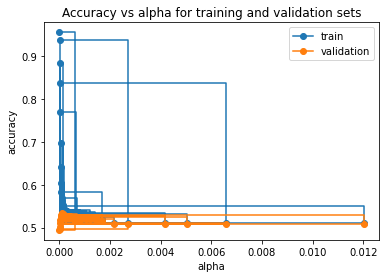

In [ ]:
train_scores = [clf.score(x_train_w2v, y_train_w2v) for clf in clfs]
test_scores = [clf.score(x_val_w2v, y_val_w2v) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="validation",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
ccp_alphas=DataFrame(ccp_alphas,columns=["alpha"])
train_scores=DataFrame(train_scores,columns=["training accuracy"])
test_scores=DataFrame(test_scores,columns=["validation accuracy"])
alpha_grid=ccp_alphas.join([train_scores,test_scores],on=None, how="left",sort=False)
optim_alpha_top5=alpha_grid.sort_values(by='validation accuracy', ascending=False).head(5)
alpha=list(set(optim_alpha_top5.alpha))
alpha

[0.00011, 0.00015, 0.00012, 9e-05, 0.0001]

In [ ]:
optim_alpha_top5

,alpha,training accuracy,validation accuracy
10,0.00010,0.561011,0.534068
2,0.00011,0.558586,0.532338
54,0.00012,0.555812,0.531612
20,0.00009,0.569387,0.531313
16,0.00015,0.547656,0.531056


In [ ]:
knn = KNeighborsClassifier(n_jobs=-1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', knn.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', knn.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.7285018582596438

Accuracy on validation data:  0.594643085992567


In [ ]:
knn = KNeighborsClassifier().fit(x_train_w2v, y_train_w2v)

param_grid =  { 'weights': ['uniform','distance'],
                'n_neighbors': [6,7]}
                                  
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(x_train_w2v, y_train_w2v)
clf_performance(best_clf_knn,'K-Nearest Neighbor')

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 338.4min finished


K-Nearest Neighbor
Best Score: 0.5884641438274656
Best Parameters: {'n_neighbors': 6, 'weights': 'distance'}


In [ ]:
knn = KNeighborsClassifier(n_jobs=-1,weights="distance",n_neighbors=6).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', knn.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', knn.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9555665403416268

Accuracy on validation data:  0.6150839420735614


In [ ]:
rf = RandomForestClassifier(random_state = 1,n_jobs=-1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', rf.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9555573863532341

Accuracy on validation data:  0.6155111281985561


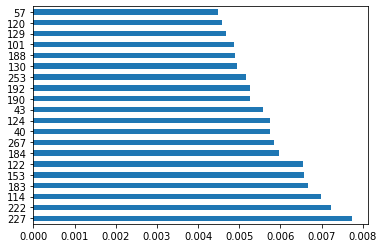

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=x_train_w2v.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
rf = RandomForestClassifier(random_state = 1,n_jobs=-1).fit(x_train_us, y_train_us)

print('Accuracy on training data: ', rf.score(x_train_us, y_train_us))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9619284940411701

Accuracy on validation data:  0.6075013883549062


In [ ]:
rf = RandomForestClassifier(random_state = 1,n_jobs=-1).fit(x_train_smote, y_train_smote)

print('Accuracy on training data: ', rf.score(x_train_smote, y_train_smote))
print()
print('Accuracy on validation data: ', rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9849552264142936

Accuracy on validation data:  0.6217480456234782


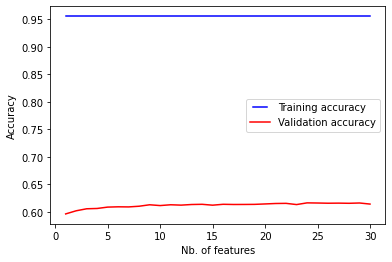

In [ ]:
max_features = np.linspace(1, 30, 30, endpoint=True)

max_features = max_features.astype(int)
train_results = []
val_results = []
for max_nb_ft in max_features:
   rf = RandomForestClassifier(random_state = 0,max_features=max_nb_ft, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Training accuracy")
line2, = plt.plot(max_features, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Nb. of features')
plt.show()

In [ ]:
max_features=DataFrame(max_features,columns=["Max. nb. of features"])
train_results=DataFrame(train_results,columns=["Training accuracy"])
val_results=DataFrame(val_results,columns=["Validation accuracy"])
features_grid=max_features.join([train_results,val_results],on=None, how="left",sort=False)
features_grid_top5=features_grid.sort_values(by='Validation accuracy', ascending=False).head(5)
features_grid_top5

,Max. nb. of features,Training accuracy,Validation accuracy
23,24,0.955567,0.616579
28,29,0.955567,0.616366
24,25,0.955567,0.616323
26,27,0.955567,0.616109
25,26,0.955567,0.615938


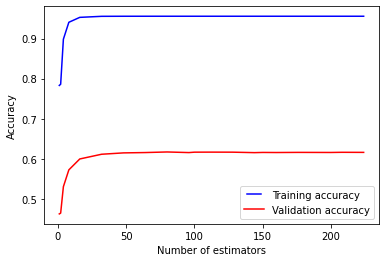

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32 ,48, 64, 80, 96,100, 112, 128, 144, 150,160,176,200,208,224]
train_results = []
val_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(random_state = 0, n_estimators=estimator,max_features=24, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Training accuracy")
line2, = plt.plot(n_estimators, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Number of estimators')
plt.show()

In [ ]:
n_estimators=DataFrame(n_estimators,columns=["Nb. of trees"])
train_results=DataFrame(train_results,columns=["Training accuracy"])
val_results=DataFrame(val_results,columns=["Validation accuracy"])
tree_grid=n_estimators.join([train_results,val_results],on=None, how="left",sort=False)
tree_grid_top5=tree_grid.sort_values(by='Validation accuracy', ascending=False).head(5)
tree_grid_top5

,Nb. of trees,Training accuracy,Validation accuracy
8,80,0.955567,0.617092
11,112,0.955567,0.616686
10,100,0.955567,0.616579
12,128,0.955567,0.616579
18,208,0.955567,0.616259


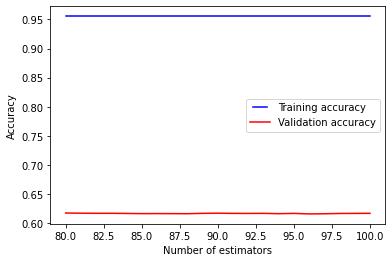

In [ ]:
n_estimators = np.linspace(80, 100, 20, endpoint=True)
n_estimators = n_estimators.astype(int)

train_results = []
val_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(random_state=0,n_estimators=estimator,warm_start=True,max_features=24, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Training accuracy")
line2, = plt.plot(n_estimators, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Number of estimators')
plt.show()


In [ ]:
n_estimators=DataFrame(n_estimators,columns=["Nb. of trees"])
train_results=DataFrame(train_results,columns=["Training accuracy"])
val_results=DataFrame(val_results,columns=["Validation accuracy"])
tree_grid=n_estimators.join([train_results,val_results],on=None, how="left",sort=False)
tree_grid_top5=tree_grid.sort_values(by='Validation accuracy', ascending=False).head(5)
tree_grid_top5

,Nb. of trees,Training accuracy,Validation accuracy
0,80,0.955567,0.617092
1,81,0.955567,0.616814
10,90,0.955567,0.616793
3,83,0.955567,0.616643
2,82,0.955567,0.616600


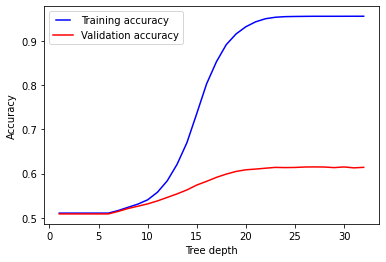

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
val_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(random_state=0,max_depth=max_depth,max_features=24,n_estimators=80,n_jobs=-1).fit(x_train_w2v, y_train_w2v)
   score_train=rf.score(x_train_w2v, y_train_w2v)
   score_val=rf.score(x_val_w2v, y_val_w2v)
   train_results.append(score_train)
   val_results.append(score_val)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Training accuracy")
line2, = plt.plot(max_depths, val_results, 'r', label="Validation accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
max_depths=DataFrame(max_depths,columns=["Max. depth"])
train_results=DataFrame(train_results,columns=["Training accuracy"])
val_results=DataFrame(val_results,columns=["Validation accuracy"])
max_depth_grid=max_depths.join([train_results,val_results],on=None, how="left",sort=False)
max_depth_grid_top5=max_depth_grid.sort_values(by='Validation accuracy', ascending=False).head(5)
max_depth_grid_top5

,Max. depth,Training accuracy,Validation accuracy
26,27.0,0.955484,0.614956
29,30.0,0.955502,0.614892
25,26.0,0.955292,0.614721
27,28.0,0.955457,0.614699
31,32.0,0.955557,0.613995


In [ ]:
rf = RandomForestClassifier().fit(x_train_w2v, y_train_w2v)

param_grid =  {'criterion':['gini'],
                                  'random_state': [0],
                                  'bootstrap': [True],
                                  'max_features': [24],
                                  'max_depth' : [26,27,28],
                                  'n_estimators': [80,81,82]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 4, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(x_train_w2v, y_train_w2v)
clf_performance(best_clf_rf,'Random Forest')

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 108.9min finished


Random Forest
Best Score: 0.6046666929270601
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 28, 'max_features': 24, 'n_estimators': 81, 'random_state': 0}


In [ ]:
best_rf = RandomForestClassifier(random_state=0,max_depth=28,max_features=24,n_estimators=81,n_jobs=-1).fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', best_rf.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', best_rf.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.9554566924809139

Accuracy on validation data:  0.6148703490110641


In [ ]:
abc = AdaBoostClassifier().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', abc.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', abc.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5545394628439612

Accuracy on validation data:  0.5520099107180999


In [ ]:
gbc = GradientBoostingClassifier().fit(x_train_w2v, y_train_w2v)

print('Accuracy on training data: ', gbc.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', gbc.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.6073213599165156

Accuracy on validation data:  0.5889187919176385


In [ ]:
xgb = XGBClassifier(random_state =1, n_jobs=-1).fit(x_train_w2v, y_train_w2v)
print('Accuracy on training data: ', xgb.score(x_train_w2v, y_train_w2v))
print()
print('Accuracy on validation data: ', xgb.score(x_val_w2v, y_val_w2v))

Accuracy on training data:  0.5845187748301935

Accuracy on validation data:  0.5756546627365543


In [ ]:
from tensorflow import keras
import IPython
!pip install -q -U keras-tuner

import tensorflow as tf
import kerastuner as kt
from keras.models import Sequential
from keras.layers import Input,Dense
from kerastuner.tuners import BayesianOptimization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score,classification_report

     |████████████████████████████████| 71kB 3.7MB/s 


In [ ]:
# I start by attempting to find the best setting for a feed-forward network with 1 hidden layer.

import kerastuner as kt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from kerastuner.tuners import BayesianOptimization


def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    ),input_shape=(300,)))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 32,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'Feed_fwd_12', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 360
EPOCHS = 32

bayesian_opt_tuner.search(x_train_w2v, y_train_w2v,
             epochs=EPOCHS,
             validation_data=(x_val_w2v,y_val_w2v),
             validation_steps=360,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. The optimal activation function is {best_hps.get('dense_activation')}. 
""")

Trial 90 Complete [00h 00m 47s]
val_accuracy: 0.5249263048171997

Best val_accuracy So Far: 0.5456021428108215
Total elapsed time: 00h 20m 38s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 640 and the optimal learning rate for the optimizer
is 0.001. The optimal activation function is selu. 



In [ ]:
#I now fit the optimal model above with 1 hidden layer and supervise the evolution of accuracy per epoch.

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report

tf.random.set_seed(0)
epochs = 183 
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
best_nn = Sequential()
best_nn.add(Dense(640, activation='selu', input_shape=(300,)))
best_nn.add(Dense(5, activation='softmax'))
best_nn.compile(loss=loss,optimizer=optimizer,metrics= metrics)
model.fit(x_train_w2v, y_train_w2v,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_w2v,y_val_w2v))

Epoch 1/183
114/114 [==============================] - 4s 30ms/step - loss: 1.4668 - accuracy: 0.4587 - val_loss: 1.2306 - val_accuracy: 0.5208
Epoch 2/183
114/114 [==============================] - 3s 28ms/step - loss: 1.2128 - accuracy: 0.5195 - val_loss: 1.1748 - val_accuracy: 0.5317
Epoch 3/183
114/114 [==============================] - 3s 28ms/step - loss: 1.1621 - accuracy: 0.5320 - val_loss: 1.1418 - val_accuracy: 0.5453
Epoch 4/183
114/114 [==============================] - 3s 29ms/step - loss: 1.1372 - accuracy: 0.5385 - val_loss: 1.1047 - val_accuracy: 0.5483
Epoch 5/183
114/114 [==============================] - 3s 28ms/step - loss: 1.1026 - accuracy: 0.5480 - val_loss: 1.1062 - val_accuracy: 0.5436
Epoch 6/183
114/114 [==============================] - 3s 28ms/step - loss: 1.0932 - accuracy: 0.5481 - val_loss: 1.0965 - val_accuracy: 0.5491
Epoch 7/183
114/114 [==============================] - 3s 28ms/step - loss: 1.0979 - accuracy: 0.5489 - val_loss: 1.0918 - val_accuracy:

In [ ]:
score_train=best_nn.evaluate(x_train_w2v, y_train_w2v,batch_size=batch_size)
score_val=best_nn.evaluate(x_val_w2v, y_val_w2v,batch_size=batch_size)
best_nn.metrics_names

49/49 [==============================] - 1s 12ms/step - loss: 0.9904 - accuracy: 0.5934


['loss', 'accuracy']

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    ),input_shape=(300,)))
    model.add(Dense(units=hp.Int('units_0',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation_0',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    )))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 32,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'Feed_fwd_13', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 360
EPOCHS = 32

bayesian_opt_tuner.search(x_train_w2v, y_train_w2v,
             epochs=EPOCHS,
             validation_data=(x_val_w2v,y_val_w2v),
             validation_steps=360,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -{best_hps.get('units')} for the first layer,
 -{best_hps.get('units_0')} for the second layer.

The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 

The optimal activation functions are:
 -{best_hps.get('dense_activation')} for the first layer,
 -{best_hps.get('dense_activation_0')} for the second layer.
 """)

Trial 90 Complete [00h 01m 54s]
val_accuracy: 0.5087359547615051

Best val_accuracy So Far: 0.5543166995048523
Total elapsed time: 00h 37m 57s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -152 for the first layer,
 -432 for the second layer.

The optimal learning rate for the optimizer is 0.001. 

The optimal activation functions are:
 -selu for the first layer,
 -relu for the second layer.
 


In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report

tf.random.set_seed(0)


epochs = 58
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = Sequential()
model.add(Dense(152, activation='selu', input_shape=(300,)))
model.add(Dense(432, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
model.fit(x_train_w2v, y_train_w2v,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_w2v,y_val_w2v))

Epoch 1/58
114/114 [==============================] - 4s 27ms/step - loss: 1.3128 - accuracy: 0.4910 - val_loss: 1.1846 - val_accuracy: 0.5252
Epoch 2/58
114/114 [==============================] - 3s 23ms/step - loss: 1.1720 - accuracy: 0.5293 - val_loss: 1.0847 - val_accuracy: 0.5468
Epoch 3/58
114/114 [==============================] - 3s 23ms/step - loss: 1.0955 - accuracy: 0.5480 - val_loss: 1.1096 - val_accuracy: 0.5508
Epoch 4/58
114/114 [==============================] - 3s 23ms/step - loss: 1.0653 - accuracy: 0.5594 - val_loss: 1.0174 - val_accuracy: 0.5779
Epoch 5/58
114/114 [==============================] - 3s 23ms/step - loss: 1.0310 - accuracy: 0.5735 - val_loss: 1.0405 - val_accuracy: 0.5775
Epoch 6/58
114/114 [==============================] - 3s 22ms/step - loss: 1.0344 - accuracy: 0.5722 - val_loss: 1.0222 - val_accuracy: 0.5679
Epoch 7/58
114/114 [==============================] - 3s 22ms/step - loss: 1.0056 - accuracy: 0.5813 - val_loss: 1.0158 - val_accuracy: 0.5916

In [ ]:
score_train=model.evaluate(x_train_w2v, y_train_w2v,batch_size=batch_size)
score_val=model.evaluate(x_val_w2v, y_val_w2v,batch_size=batch_size)
model.metrics_names

49/49 [==============================] - 0s 8ms/step - loss: 0.9243 - accuracy: 0.6190


['loss', 'accuracy']

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units',min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    ),input_shape=(300,)))
    for i in range(hp.Int('num_layers', 1, 2)):
          model.add(Dense(units=hp.Int('units_' + str(i),min_value=0,
                                        max_value=640,
                                        step=4), activation=hp.Choice(
        'dense_activation_' + str(i),
        values=['relu', 'tanh', 'sigmoid','elu','selu','swish'],
        default='sigmoid'
    )))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model
  
# define model
bayesian_opt_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 32,
                     factor = 3,
                     directory = '/content/',
                     project_name = 'Feed_fwd_14', seed=0)

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

EVALUATION_INTERVAL = 360
EPOCHS = 32

bayesian_opt_tuner.search(x_train_w2v, y_train_w2v,
             epochs=EPOCHS,
             validation_data=(x_val_w2v,y_val_w2v),
             validation_steps=360,
             steps_per_epoch=EVALUATION_INTERVAL,
             batch_size=960
             , callbacks = [ClearTrainingOutput()]
             )

# Get the optimal hyperparameters
best_hps = bayesian_opt_tuner.get_best_hyperparameters(num_trials = 10)[0]

print(f"""
The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -{best_hps.get('units')} for the first layer,
 -{best_hps.get('units_0')} for the second layer,
 -{best_hps.get('units_1')} for the third layer.

The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 

The optimal activation functions are:
 -{best_hps.get('dense_activation')} for the first layer,
 -{best_hps.get('dense_activation_0')} for the second layer,
 -{best_hps.get('dense_activation_1')} for the third layer.
 """)

Trial 90 Complete [00h 02m 38s]
val_accuracy: 0.531205952167511

Best val_accuracy So Far: 0.557819664478302
Total elapsed time: 00h 41m 27s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal numbers of units in the densely-connected
layers are: 
 -536 for the first layer,
 -476 for the second layer,
 -80 for the third layer.

The optimal learning rate for the optimizer is 0.0001. 

The optimal activation functions are:
 -relu for the first layer,
 -tanh for the second layer,
 -relu for the third layer.
 


In [ ]:


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Dense
from sklearn.metrics import accuracy_score,classification_report

tf.random.set_seed(0)


epochs = 56
batch_size = 960
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(0.0001)
metrics = ["accuracy"]

from keras import models

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Build neural network
model = Sequential()
model.add(Dense(536, activation='relu', input_shape=(300,)))
model.add(Dense(476, activation='tanh'))
model.add(Dense(80, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss=loss,optimizer=optimizer,metrics= metrics)
model.fit(x_train_w2v, y_train_w2v,epochs=epochs,batch_size=batch_size,callbacks=callbacks,validation_data=(x_val_w2v,y_val_w2v))

Epoch 1/56
114/114 [==============================] - 8s 66ms/step - loss: 1.3423 - accuracy: 0.4729 - val_loss: 1.2524 - val_accuracy: 0.5087
Epoch 2/56
114/114 [==============================] - 7s 64ms/step - loss: 1.2428 - accuracy: 0.5106 - val_loss: 1.1990 - val_accuracy: 0.5160
Epoch 3/56
114/114 [==============================] - 7s 63ms/step - loss: 1.1901 - accuracy: 0.5221 - val_loss: 1.1492 - val_accuracy: 0.5416
Epoch 4/56
114/114 [==============================] - 7s 64ms/step - loss: 1.1368 - accuracy: 0.5424 - val_loss: 1.0995 - val_accuracy: 0.5542
Epoch 5/56
114/114 [==============================] - 7s 65ms/step - loss: 1.0880 - accuracy: 0.5575 - val_loss: 1.0768 - val_accuracy: 0.5741
Epoch 6/56
114/114 [==============================] - 7s 63ms/step - loss: 1.0572 - accuracy: 0.5707 - val_loss: 1.0469 - val_accuracy: 0.5800
Epoch 7/56
114/114 [==============================] - 7s 63ms/step - loss: 1.0331 - accuracy: 0.5764 - val_loss: 1.0196 - val_accuracy: 0.5790

In [ ]:
score_train=model.evaluate(x_train_w2v, y_train_w2v,batch_size=batch_size)
score_val=model.evaluate(x_val_w2v, y_val_w2v,batch_size=batch_size)
model.metrics_names

49/49 [==============================] - 1s 22ms/step - loss: 0.9271 - accuracy: 0.6167


['loss', 'accuracy']

## Fitting the final model on the test data and making the submission

The best model in terms of the bias-variance trade-off (with a validation accuracy of 59.34%)  consists of a feed-forward neural network with one hidden layer. The accuracy of the model on the test data (after submitting the answer to Kaggle) is only 53.54%. This is mainly due to the highly unbalanced training and test datasets that mostly contain neutral reviews (mainly incomplete sentences with sentiment values) along with the relatively small number of words used in training the model.

In [ ]:
best_neural_network_pred = pd.DataFrame(model.predict_classes(x_test_w2v),columns=["Sentiment"])

#convert output to dataframe 
final_data = {'PhraseId': test.PhraseId, 'Sentiment': best_neural_network_pred.Sentiment}

In [ ]:
submission_1 = pd.DataFrame(data=final_data)
submission_1.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,3
3,156064,3
4,156065,3


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
submission_1.to_csv("/content/drive/MyDrive/Rotten tomatoes/Rotten_Tomatoes_sentiment_classification_submission_1.csv",index=False)